In [12]:
import pandas as pd
import numpy as np
from os import walk
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Input, MaxPooling1D, Dropout, Flatten, concatenate
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.optimizers import Adam

from mpnn import *


In [2]:
filenames = next(walk("dataset/full"), (None, None, []))[2]
filenames

['SK-PN-DW_specific_16501_genes_4_features_df.txt',
 'LU-165_specific_16501_genes_4_features_df.txt',
 'RERF-LC-Sq1_specific_16501_genes_4_features_df.txt',
 'NB7_specific_16501_genes_4_features_df.txt',
 'GRANTA-519_specific_16501_genes_4_features_df.txt',
 'KYSE-140_specific_16501_genes_4_features_df.txt',
 'HMV-II_specific_16501_genes_4_features_df.txt',
 'LB771-HNC_specific_16501_genes_4_features_df.txt',
 'BB30-HNC_specific_16501_genes_4_features_df.txt',
 'NCI-H1734_specific_16501_genes_4_features_df.txt',
 'IHH-4_specific_16501_genes_4_features_df.txt',
 'RKN_specific_16501_genes_4_features_df.txt',
 'KARPAS-620_specific_16501_genes_4_features_df.txt',
 'CAL-148_specific_16501_genes_4_features_df.txt',
 'KMS-11_specific_16501_genes_4_features_df.txt',
 'FU97_specific_16501_genes_4_features_df.txt',
 'HD-MY-Z_specific_16501_genes_4_features_df.txt',
 'TE-12_specific_16501_genes_4_features_df.txt',
 'SK-LMS-1_specific_16501_genes_4_features_df.txt',
 'NCI-H2171_specific_16501_gene

In [3]:
cell_line_features = pd.read_csv("dataset/full/"+filenames[1], sep='\t')
cell_line_name = filenames[0].split("_")[0]
cell_line_name

'SK-PN-DW'

In [4]:
drug_cell_pairs_raw = pd.read_csv("dataset/GDSC_338K_drug_response_and_cansyl_drug_cell_line_pairs_concatenated.txt", sep='\t')
drug_cell_pairs_raw.rename(columns = {'DRUG_NAME':'drug_name', 'CELL_LINE_NAME':'cell_line_name', 'pIC50': 'pic50'}, inplace = True)
drug_cell_pairs_all = drug_cell_pairs_raw.loc[drug_cell_pairs_raw['cell_line_name'] == cell_line_name]
drug_cell_pairs = drug_cell_pairs_all.iloc[0]
drug_name = drug_cell_pairs['drug_name']
pic50 = drug_cell_pairs['pic50']
drug_cell_pairs

drug_name         (5Z)-7-Oxozeaenol
cell_line_name             SK-PN-DW
pic50                       5.24648
Name: 778, dtype: object

In [5]:
drug_smiles_raw = pd.read_csv("dataset/GDSC_drug_name_SMILES_and_ECFP4_v2.txt",sep='\t')
drug_smiles_raw.rename(columns = {'DRUG_NAME':'drug_name', 'SMILES':'smiles', 'ECFP4': 'ecfp4'}, inplace = True)
drug_smiles = drug_smiles_raw.loc[drug_smiles_raw['drug_name'] == drug_name]
smiles = drug_smiles['smiles']
drug_smiles

,drug_name,smiles,ecfp4
386,(5Z)-7-Oxozeaenol,CC1CC=CC(=O)C(C(CC=CC2=C(C(=CC(=C2)OC)O)C(=O)O...,0000000000000000000000000000000001000000000000...


In [6]:
x_train = np.asarray(np.expand_dims(a[a.columns[1:4]],axis=-1))
x_train.shape

NameError: name 'a' is not defined

In [97]:
y_train = np.asarray(a[a.columns[4]])

array([2., 1., 1., ..., 2., 1., 2.])

In [7]:
chemprop = Input((64,))

Metal device set to: Apple M1


2022-05-27 13:27:54.826893: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-27 13:27:54.827471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "final_output"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 3, 64)        192         input_layer[0][0]                
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 3, 64)        4160        conv_1[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 3, 64)        0           conv_2[0][0]                     
_______________________________________________________________________________________

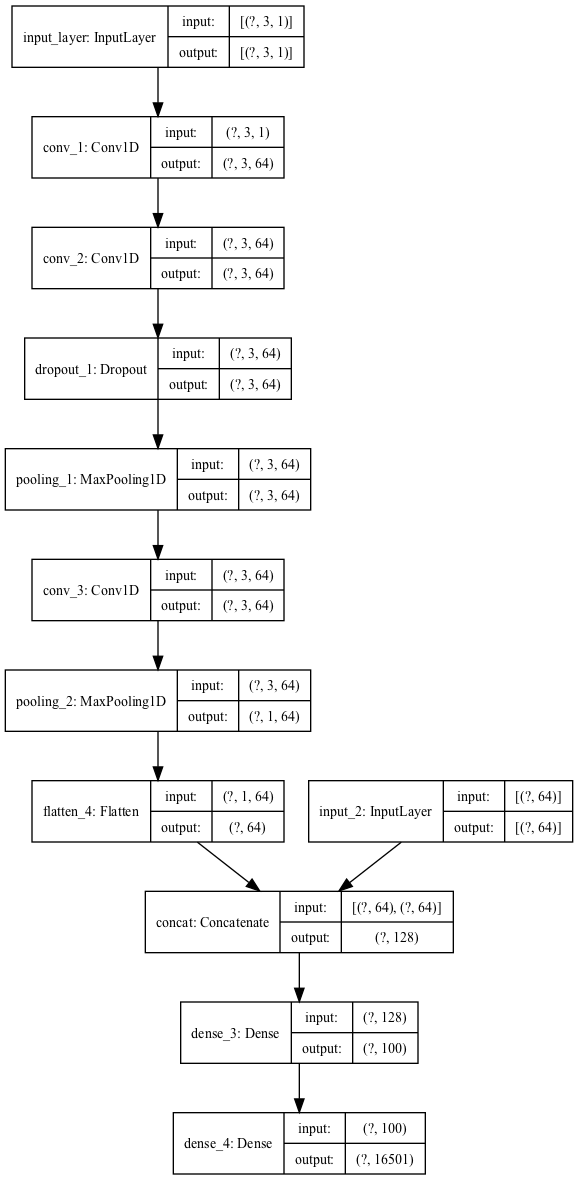

In [8]:
input_layer = Input(shape=(3,1),name='input_layer')
conv_1 = Conv1D(64, 2,strides=1,padding='same', activation='relu',name='conv_1')(input_layer)
conv_2 = Conv1D(64, 1,strides=1,padding='same', activation='relu',name='conv_2')(conv_1)
dropout_1 = Dropout(0.5, name= 'dropout_1')(conv_2)
pooling_1 = MaxPooling1D(1, name = 'pooling_1')(dropout_1)
conv_3 = Conv1D(64, 1, activation='relu',name='conv_3')(pooling_1)
pooling_2 = MaxPooling1D(2, name = 'pooling_2')(conv_3)
flatten_1 = Flatten()(pooling_2)

concat = concatenate([flatten_1, chemprop], name='concat')

dense_1 = Dense(100, activation='relu')(concat)
dense_2 = Dense(16501, activation='sigmoid')(dense_1)

merged = Model(inputs=[input_layer,chemprop],outputs=[dense_2],name= 'final_output')

merged.summary()

plot_model(merged, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')